<a href="https://colab.research.google.com/github/tarod13/OptimalControl/blob/main/OptimalControl_DP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Programming project

First, we'll load the necessary libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter
import math

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

seed = 23
np.random.seed(seed)

## 1. Methods 

### 1.1 Trajectory simulations
We need to defined methods that allow simulating trajectories based on the differential equation $\dot{x}(t)=Ax(t)+Bu(t)$ that specify the system being controlled.

We will use the Dormand-Prince method to simulate the dynamics. For this, we will define an integration step method that receives as input the state-action pair $(x(t),u(t))$ and approximates the corresponding adjusted derivative $\frac{dx}{dt}$. Then, we introduce a second method that executes several times the step, to produce a trajectory where $x[k+1]\leftarrow x[k]+\frac{dx}{dt}\Delta t$.  

In [4]:
# Dormand-Prince integration step
def step_DormandPrince(f,t,x,h,u,f_args):

    k1 = f(t,x,u,f_args)
    x2 = x + h*(1./5.*k1)
    k2 = f(t + 1./5.*h, x2, u, f_args)
    x3 = x + h*(3./40.*k1 + 9./40.*k2)
    k3 = f(t + 3./10*h, x3, u, f_args)
    x4 = x + h*(44./45.*k1 - 56./15.*k2 + 32./9.*k3)
    k4 = f(t + 4./5.*h, x4, u, f_args)
    x5 = x + h*(19372./6561.*k1 - 25360./2187.*k2 + 64448./6561.*k3 - 212./729.*k4)
    k5 = f(t + 8./9.*h, x5, u, f_args)
    x6 = x + h*(9017./3168.*k1 - 355./33.*k2 + 46732./5247.*k3 + 49./176.*k4 - 5103./18656.*k5)
    k6 = f(t + h, x6, u, f_args)

    dx_dt = 35./384.*k1 + 500./1113.*k3 + 125./192.*k4 - 2187./6784.*k5 + 11./84.*k6    
    return dx_dt

In [106]:
# Dormand-Prince simulation with forced input
def simulate_trajectory_DormandPrince(f, t, t_k, x0, f_args, NA=21, 
                                      policy_init_type='simple', 
                                      policy_type='simple', policy=None, A0=None):
    N = len(t)
    x_last = x0.copy()
    x = [x0]
    u0, a0, s0 = x2u(x0, policy_init_type, policy, NA, A0)
    u, a, s = [u0], [a0], [s0]
    j = 0

    for i in range(0, N-1):
        dx_dt = step_DormandPrince(f,t[i],x_last,t[i+1]-t[i],u[j],f_args)
        dt = t[i+1]-t[i]
        x_last = x_last + dx_dt*dt

        if t[i+1] >= t_k[j+1]:
          j += 1
          x.append(x_last.copy())
          u_last, a_last, s_last = x2u(x_last, policy_type, policy, NA, A0)
          u.append(u_last)
          a.append(a_last)
          s.append(s_last)

    return np.stack(x), np.stack(s), np.stack(a), np.stack(u)

def simulate_trajectory_DormandPrince_actor(f, t, t_k, x0, f_args, actor, rand_init=False):
    N = len(t)
    x_last = x0.copy()
    x = [x0]
    u0, a0, s0 = x2u_direct(x0, actor, rand_sample=rand_init)
    u, a, s = [u0], [a0], [s0]
    j = 0

    for i in range(0, N-1):
        dx_dt = step_DormandPrince(f,t[i],x_last,t[i+1]-t[i],u[j],f_args)
        dt = t[i+1]-t[i]
        x_last = x_last + dx_dt*dt

        if t[i+1] >= t_k[j+1]:
          j += 1
          x.append(x_last.copy())
          u_last, a_last, s_last = x2u_direct(x_last, actor)
          u.append(u_last)
          a.append(a_last)
          s.append(s_last)

    return np.stack(x), np.stack(s), np.stack(a), np.stack(u)

# # Dormand-Prince simulation with forced input
# def simulate_trajectory_DormandPrince(f, t, t_k, x0, f_args):
#     N = len(t)
#     x = [x0]
#     u0, a0, s0 = x2u(x0)
#     u, a, s = [u0], [a0], [s0]
#     j = 0    
#     for i in range(0, N-1):
#         dx_dt = step_DormandPrince(f,t[i],x[i],t[i+1]-t[i],u[i],f_args)
#         dt = t[i+1]-t[i]
#         x.append(x[i] + dx_dt*dt)
#         if t[i+1] > t_k[j+1]:
#           j += 1
#           u_ip1, a_ip1, s_ip1 = x2u(x[i+1])
#           u.append(u_ip1)
#           a.append(a_ip1)
#           s.append(s_ip1)
#         else:
#           u.append(u[i])
#           a.append(a[i])
#           s.append(s[i])
#     return np.stack(x), np.stack(s), np.stack(a), np.stack(u)

In [6]:
# Define system dynamics
def system_ode(t, x, u, args):
  A = args['A']; B = args['B']
  xdot = np.einsum('ij,kj->ki',A,x) + np.einsum('ij,kj->ki',B,u)  
  return xdot

### 1.2 Conversion methods and initial policy
We need to discretize the states to apply the tabular version of the DP algortihms. Also, to control the system from the policy we will need to convert discrete actions into control signals. 

In [7]:
# State in original coordinates to DP discrete state
def x2s(x, x_min=-1.0, x_max=1.0, NS=101):
  x_clip = x.clip(x_min, x_max-(x_max-x_min)/NS)
  x_unit = (x_clip - x_min) / (x_max-x_min)
  s_float = x_unit * NS
  s = np.floor(s_float).astype('int')
  return s  

In [8]:
# Action taken by initial policy
def simple_policy(state, NS=101, NA=21):
  s_0 = (NS-1)//2
  a_0 = (NA-1)//2
  if state[0] == s_0 and state[1] == s_0:
    return a_0
  elif state[0] > s_0 and state[1] >= s_0:
    return 0
  elif state[0] >= s_0 and state[1] < s_0:
    return a_0+2
  elif state[0] < s_0 and state[1] <= s_0:
    return NA-1
  elif state[0] <= s_0 and state[1] > s_0:
    return a_0-2
  else:
    print(state[0], state[1])
    raise NameError('Invalid state')

In [9]:
# Initial policy that takes state to origin
def s2a_simple_policy(s, NS=101):
  n_s = s.shape[0]
  a_list = [simple_policy(state) for state in s.tolist()]
  a = np.array(a_list).reshape(-1,1)
  return a

def s2a(s, policy):
  s_list = np.transpose(s).tolist()
  a = policy[tuple(s_list)].reshape(-1,1)
  return a 

In [10]:
# DP discrete action to control signal 
def a2u(a, u_min=-1.0, u_max=1.0, NA=21):
  a_unit = a.astype('float') / float(NA-1)
  u = a_unit * (u_max-u_min) + u_min
  return u

def u2a(u, u_min=-1.0, u_max=1.0, NA=21):
  u_clip = u.clip(u_min, u_max-(u_max-u_min)/NA)
  u_unit = (u_clip - u_min) / (u_max-u_min)
  a_float = u_unit * NA
  a = np.floor(a_float).astype('int')
  return a 

In [114]:
# State to control signal
def x2u(x, policy_type='simple', policy=None, NA=21, A0=None):
  s = x2s(x)
  if policy_type == 'simple':
    a = s2a_simple_policy(s)
  elif policy_type == 'random':
    a = np.random.randint(NA, size=(s.shape[0],1))
  elif policy_type == 'given_policy' and policy is not None:
    a = s2a(s, policy)
  elif policy_type == 'given_action' and A0 is not None:
    a = A0*np.ones((s.shape[0], 1), dtype='int') 
  else:
    raise NameError('Undefined policy')
  u = a2u(a)
  return u, a, s

def x2u_direct(x, actor, rand_sample=False, u_min=-1.0, u_max=1.0):
  s = x2s(x)
  if not rand_sample:
    with torch.no_grad():
      x_torch = torch.FloatTensor(x)
      u_torch = actor(x_torch)
      u = u_torch.numpy()
  else:
    u_unit = np.random.rand(x.shape[0],1)
    u = u_unit * (u_max-u_min) + u_min
  a = u2a(u)
  return u, a, s

### 1.3 DP methods 

In [12]:
# Initialize J table
def init_J_table_empty(NS=101):
  J_table = np.zeros((NS,NS))
  return J_table.copy()

def generate_init_states_grid(x_min=-1.0, x_max=1.0, NS=101):
  x1 = np.linspace(x_min, x_max, NS, endpoint=False) + (x_max-x_min)/(2*NS) 
  x1, x2 = np.meshgrid(x1, x1)
  x0 = np.stack([x1.reshape(-1), x2.reshape(-1)], axis=1)
  #x0 = x0[np.arange(x0.shape[0]-1,-1,-1)]
  return x0

def generate_init_states(n_points, x_min=-1.0, x_max=1.0):
  x0 = np.random.rand(n_points, 2)
  x0_scaled = x0 * (x_max - x_min) + x_min
  return x0_scaled

def generate_state_noise(n_points, x_min=-1.0, x_max=1.0, NS=101):
  x0 = np.random.rand(n_points, 2) - 0.5
  x0_scaled = x0 * (x_max - x_min) / NS
  return x0_scaled

def init_J_table(NS=101, dt_sim=0.01, dt=0.04):
  J_table = init_J_table_empty(NS)
  N_table = np.zeros((NS,NS))
  x0 = generate_init_states_grid()
  x0 = x0 + generate_state_noise(n_points=x0.shape[0])
  t = np.arange(0,100,dt_sim)
  t_k = np.arange(0,100+dt,dt)
  
  x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args)
  s0 = s[0,:,:]
  
  for i in range(0, x0.shape[0]):
    trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
    J = calculate_J_trajectory(trajectory, np.zeros((NS,NS)), dt=dt)
    
    N_new = N_table[s0[i,0], s0[i,1]] + 1
    N_table[s0[i,0], s0[i,1]] = N_new
    J_table[s0[i,0], s0[i,1]] += (J - J_table[s0[i,0], s0[i,1]]) / N_new

  return J_table.copy(), N_table.copy(), x0

def init_Q_table(J_table, NS=101, NA=21, dt_sim=0.01, dt=0.04):
  Q_table = np.zeros((NS,NS,NA))
  NSA_table = np.zeros((NS,NS,NA))
  x0 = generate_init_states_grid()
  t = np.arange(0,dt+dt_sim,dt_sim)
  t_k = np.arange(0,dt+dt,dt)
  
  for A0 in range(0, NA):
    x0_with_noise = x0 + generate_state_noise(n_points=x0.shape[0])
    x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0_with_noise,ode_args,
                                                   policy_init_type='given_action', A0=A0)
    s0 = s[0,:,:]
    
    for i in range(0, x0.shape[0]):
      trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
      J = calculate_J_trajectory(trajectory, J_table, dt=dt)
      
      N_new = NSA_table[s0[i,0], s0[i,1], A0] + 1
      NSA_table[s0[i,0], s0[i,1], A0] = N_new
      Q_table[s0[i,0], s0[i,1], A0] += (J - Q_table[s0[i,0], s0[i,1], A0]) / N_new

  return Q_table.copy(), NSA_table.copy()

def update_J_table(J_table0, policy, NS=101, n_iter=100, dt_sim=0.01, dt=0.04, alpha=1e-3):
  J_table1 = J_table0.copy()
  N_table = 10*np.ones((NS,NS))
  x0 = generate_init_states_grid()
  
  t = np.arange(0,50*dt+dt_sim,dt_sim)
  t_k = np.arange(0,50*dt+dt,dt)
  
  for iter in range(0, n_iter):
    x0_with_noise = x0 + generate_state_noise(n_points=x0.shape[0])
    x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0_with_noise,ode_args,
                                                  policy_type='given_policy', policy=policy)
    s0 = s[0,:,:]
    
    for i in range(0, x0.shape[0]):
      trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
      J = calculate_J_trajectory(trajectory, J_table0, dt=dt)
          
      N_new = N_table[s0[i,0], s0[i,1]] + 1
      N_table[s0[i,0], s0[i,1]] = N_new
      J_table1[s0[i,0], s0[i,1]] += (J - J_table1[s0[i,0], s0[i,1]]) / N_new

  return J_table1.copy(), N_table.copy()


def update_Q_table(J_table0, Q_table0, policy0, NS=101, NA=21, n_iter=100, dt_sim=0.01, dt=0.04, alpha=1e-3):
  Q_table = Q_table0.copy()  
  NSA_table = 10*np.ones((NS,NS,NA))
  x0 = generate_init_states_grid()
    
  t = np.arange(0,10*dt+dt_sim,dt_sim)
  t_k = np.arange(0,10*dt+dt,dt)
  
  for iter in range(0, n_iter):
    for A0 in range(0, NA):
      x0_with_noise = x0 + generate_state_noise(n_points=x0.shape[0])
      x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0_with_noise,ode_args,
                                                    policy_init_type='given_action', 
                                                    policy_type='given_policy', policy=policy0,
                                                    A0=A0)
      s0 = s[0,:,:]
      
      for i in range(0, x0.shape[0]):
        trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
        J = calculate_J_trajectory(trajectory, J_table0, dt=dt)
        
        NSA_new = NSA_table[s0[i,0], s0[i,1], A0] + 1
        NSA_table[s0[i,0], s0[i,1], A0] = NSA_new
        Q_table[s0[i,0], s0[i,1], A0] += (J - Q_table[s0[i,0], s0[i,1], A0]) / NSA_new

  return Q_table.copy(), NSA_table.copy()

def update_tables(J_table0, Q_table0, NS=101, NA=21, n_iter=100, dt_sim=0.01, dt=0.04, alpha=1e-3):
  policy0 = Q_table0.argmin(2)
  J_table = update_J_table(J_table0, policy0, NS, n_iter, dt_sim, dt, alpha)[0]
  Q_table = update_Q_table(J_table0, Q_table0, policy0, NS, NA, n_iter, dt_sim, dt, alpha)[0]
  return J_table.copy(), Q_table.copy()

In [95]:
# Calculate cost-to-go J for given trajectory (tuple with lists x, s, a, and u)
def calculate_J_trajectory(trajectory, J_table, mode='time-fuel', 
                           w_fuel=5.0, dt=0.04, M=500.0, NS=101, NA=21):
  s_0 = (NS-1)//2
  a_0 = (NA-1)//2
  
  J = 0.0
  finished = False
  x, s, a, u = trajectory

  if mode == 'time-fuel':
    i = 0
    while i < len(x) and not finished:            
      if (s[i,0]==s_0) and (s[i,1]==s_0):
        finished = True
      J = J + (1.0 + w_fuel * np.absolute(u[i,0]))*dt
      i = i + 1
    if not finished:
      border_1 = (s[-1,0]==0) and (s[-1,1]<s_0)
      border_2 = (s[-1,0]==(NS-1)) and (s[-1,1]>s_0)
      border_3 = (s[-1,1]==0) and (u[-1,0]<0.0)
      border_4 = (s[-1,1]==(NS-1)) and (u[-1,0]>0.0)
      stopped = (s[-1,0]!=s_0) and (s[-1,1]==0) and (a[-1,0]==a_0)
      if border_1 or border_2 or border_3 or border_4 or stopped:
        J = J + M
      else:
        J = J + J_table[s[-1,0], s[-1,1]]
  else:
    raise NameError('Undefined mode')

  return J

def calculate_J_trajectory_actor(trajectory, J_end, mode='time-fuel', 
                           w_fuel=5.0, dt=0.04, M=500.0, NS=101, NA=21):
  s_0 = (NS-1)//2
  a_0 = (NA-1)//2
  
  J = 0.0
  finished = False
  x, s, a, u = trajectory

  if mode == 'time-fuel':
    i = 0
    while i < len(x) and not finished:            
      if (s[i,0]==s_0) and (s[i,1]==s_0):
        finished = True
      J = J + (1.0 + w_fuel * np.absolute(u[i,0]))*dt
      i = i + 1
    if not finished:
      border_1 = (s[-1,0]==0) and (s[-1,1]<s_0)
      border_2 = (s[-1,0]==(NS-1)) and (s[-1,1]>s_0)
      border_3 = (s[-1,1]==0) and (u[-1,0]<0.0)
      border_4 = (s[-1,1]==(NS-1)) and (u[-1,0]>0.0)
      stopped = (s[-1,0]!=s_0) and (s[-1,1]==0) and (a[-1,0]==a_0)
      if border_1 or border_2 or border_3 or border_4 or stopped:
        J = J + M
      else:
        J = J + J_end
  else:
    raise NameError('Undefined mode')

  return J

## 2. Initial simulation with simple policy
We test our methods simulating three different initial conditions, with 2 different timesteps.

In [14]:
x0 = np.array([[0.5, 0.83], [-0.5, -0.83], [0.45, -0.1]])
A = np.array([[0.0,1.0],[0.0,0.0]])
B = np.array([[0.0],[1.0]])
ode_args = {'A': A.copy(), 'B': B.copy()}

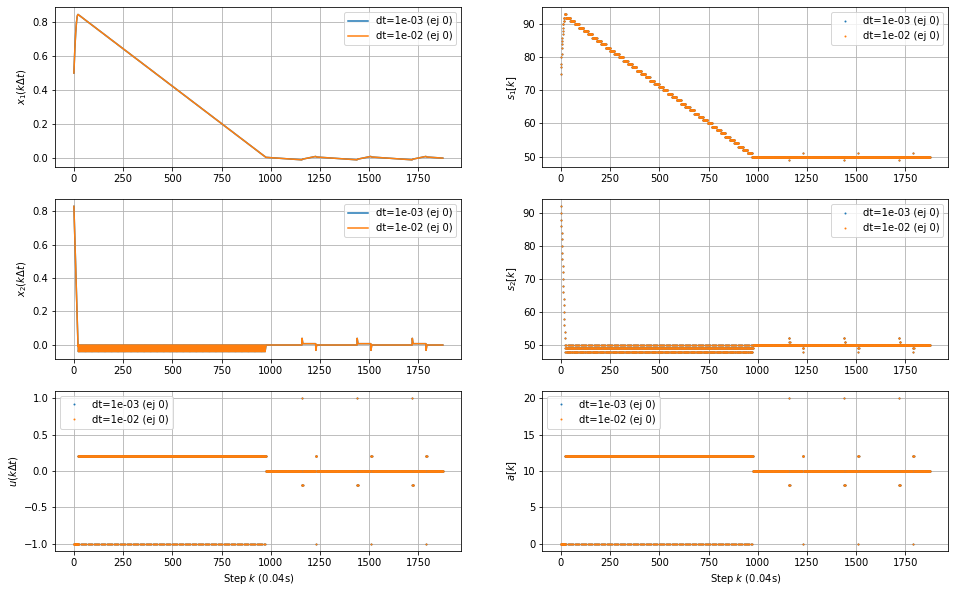

In [15]:
fig, ax = plt.subplots(3,2, figsize=(16,10))
for dt_sim in [0.001, 0.01]:
  dt = 0.04
  t = np.arange(0.0,75.0,dt_sim)
  t_k = np.arange(0.0,75.0+dt,dt)  
  x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args)
  k = np.arange(0,len(x))
  for i in range(0, 1): 
    label_ = "dt=%.0e"%dt_sim+" (ej "+str(i)+")"   
    ax[0,0].plot(k, x[:,i,0], '-', ms=1, label=label_)
    ax[1,0].plot(k, x[:,i,1], '-', ms=1, label=label_)
    ax[2,0].plot(k, u[:,i,0], 'o', ms=1, label=label_)
    ax[0,1].plot(k, s[:,i,0], 'o', ms=1, label=label_)
    ax[1,1].plot(k, s[:,i,1], 'o', ms=1, label=label_)
    ax[2,1].plot(k, a[:,i,0], 'o', ms=1, label=label_)
ax[2,0].set_xlabel('Step $k$ (0.04s)')
ax[2,1].set_xlabel('Step $k$ (0.04s)')
ax[0,0].set_ylabel('$x_1(k\Delta t)$')
ax[0,1].set_ylabel('$s_1[k]$')
ax[1,0].set_ylabel('$x_2(k\Delta t)$')
ax[1,1].set_ylabel('$s_2[k]$')
ax[2,0].set_ylabel('$u(k\Delta t)$')
ax[2,1].set_ylabel('$a[k]$')
for i in range(0,3):
  for j in range(0,2):
    ax[i,j].grid()
    ax[i,j].legend(fontsize=10)
plt.show()
plt.close() 

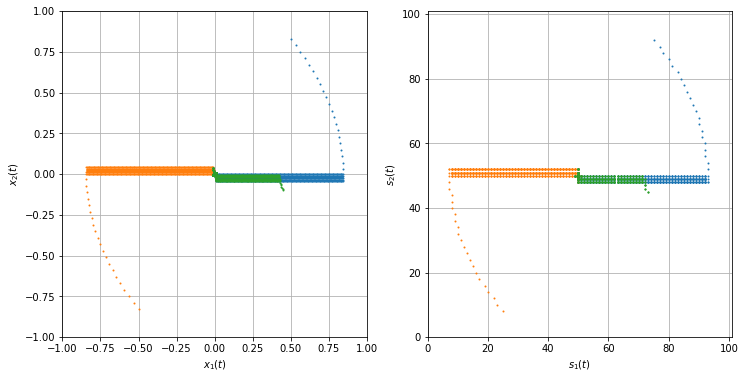

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i in range(0, x0.shape[0]): 
  ax[0].plot(x[:,i,0], x[:,i,1], 'o', ms=1)
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_xlabel(r'$x_1(t)$')
ax[0].set_ylabel(r'$x_2(t)$')

for i in range(0, x0.shape[0]): 
  ax[1].plot(s[:,i,0], s[:,i,1], 'o', ms=1)
ax[1].set_xlim([0,101])
ax[1].set_ylim([0,101])
ax[1].set_xlabel(r'$s_1(t)$')
ax[1].set_ylabel(r'$s_2(t)$')

for i in range(0, 2):
  ax[i].grid() 
plt.show()
plt.close() 

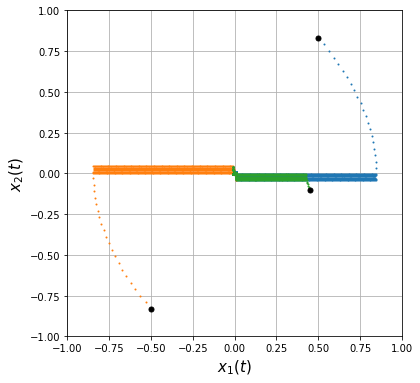

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

for i in range(0, x0.shape[0]): 
  ax.plot(x[:,i,0], x[:,i,1], 'o', ms=1)
  ax.plot(x[0,i,0], x[0,i,1], 'o', c='k', ms=5)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel(r'$x_1(t)$', fontsize=15)
ax.set_ylabel(r'$x_2(t)$', fontsize=15)

ax.grid() 
plt.savefig('trajectories_pi0.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()
plt.close() 

We can see that in all the cases the initial policy is successful in changing the state of the system to the origin. Also, it seems that precision is not heavily affected by increasing the time step $\Delta t$ from $0.001$ to $0.01$. Thus, we will fix this hyperparameter to 0.01.

In [18]:
J_table = init_J_table_empty()
J_test = []
for k in range(0, x0.shape[0]):
  trajectory = (x[:,k,:], s[:,k,:], a[:,k,:], u[:,k,:])
  J_test.append(calculate_J_trajectory(trajectory, J_table, w_fuel=5.0, dt=0.04))
print("Cost-to-go J: ", J_test)

Cost-to-go J:  [106.91999999999852, 106.91999999999852, 47.719999999999594]


In addition, we estimated the cost for the 3 different trajectories. We can see that the first 2 have the same cost, given that they are symmetric, while the third one is comparatively low, given that the initial state $x(0)$ is closer to the origin.

# 3. DP
## 3.1 Initial evaluation for the policy $\mu_0$

We will 

In [19]:
J_table, N_table = init_J_table(dt_sim=0.01, dt=0.04)[:2]

In [20]:
Q_table, NSA_table = init_Q_table(J_table)

In [21]:
# Uncomment to store
# np.savetxt('J_mu7.csv', J_table1, delimiter=',')
# np.savetxt('N_mu1.csv', N_table, delimiter=',')
# pickle.dump(Q_table1, open('Q_mu7.p', mode='wb'))

# Uncomment to load
J_table1 = np.loadtxt('J_mu7.csv', delimiter=',')
Q_table1 = pickle.load(open('Q_mu7.p', mode='rb'))

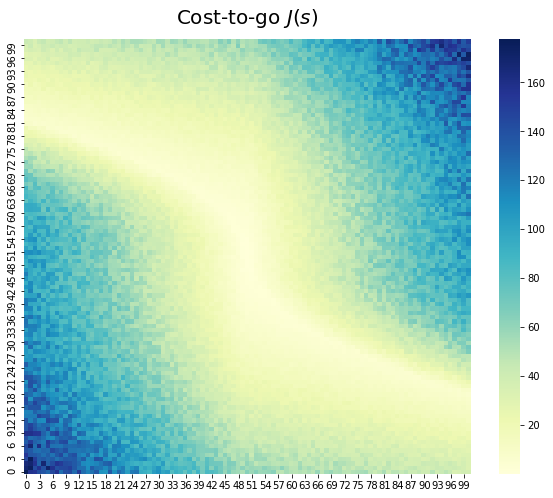

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(J_table.T, ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.title('Cost-to-go $J(s)$', fontsize=20, pad=15)
plt.show()
plt.close()

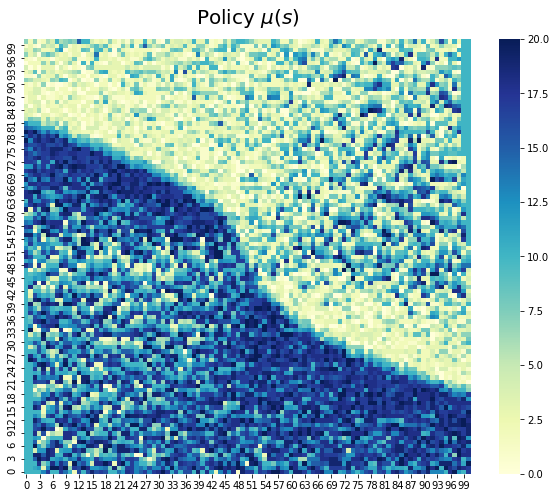

In [23]:
#policy = np.array([[np.random.choice(np.flatnonzero(Q_table[i,j,:] == Q_table[i,j,:].min())) for j in range(0,101)] for i in range(0,101)])
policy = Q_table.argmin(2)
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(policy.T, ax=ax, cmap='YlGnBu', vmax=20, vmin=0)
sns_ax.invert_yaxis()
plt.title('Policy $\mu(s)$', fontsize=20, pad=15)
plt.show()
plt.close()

We can see that after only 1 iteration of the policy improvement step, the policy found is already similar to the expected *bang-off-bang* policy. The switching curve is apparent, and for most states below this curve the control is maximally positive, while it is maximally negative for most states above the curve.

In [24]:
x0 = generate_init_states(10**6)
s0 = x2s(x0)
a0 = s2a_simple_policy(s0)
s0_list = np.transpose(s0).tolist()
a0_new = policy[tuple(s0_list)].reshape(-1,1)
p_dif = (a0 != a0_new).sum() / a0.shape[0] * 100
print("Percentage of difference between initial policy and policy after one policy improvement step: {:.2f}%".format(p_dif))
del x0; del s0; del s0_list; del a0; del a0_new

Percentage of difference between initial policy and policy after one policy improvement step: 95.94%


Comparing the policy obtained with the initial policy, we obtain a difference of $82.74\%$. This tells us that even if the initial policy was a good starting point, one improvement step resulted in a large change. 

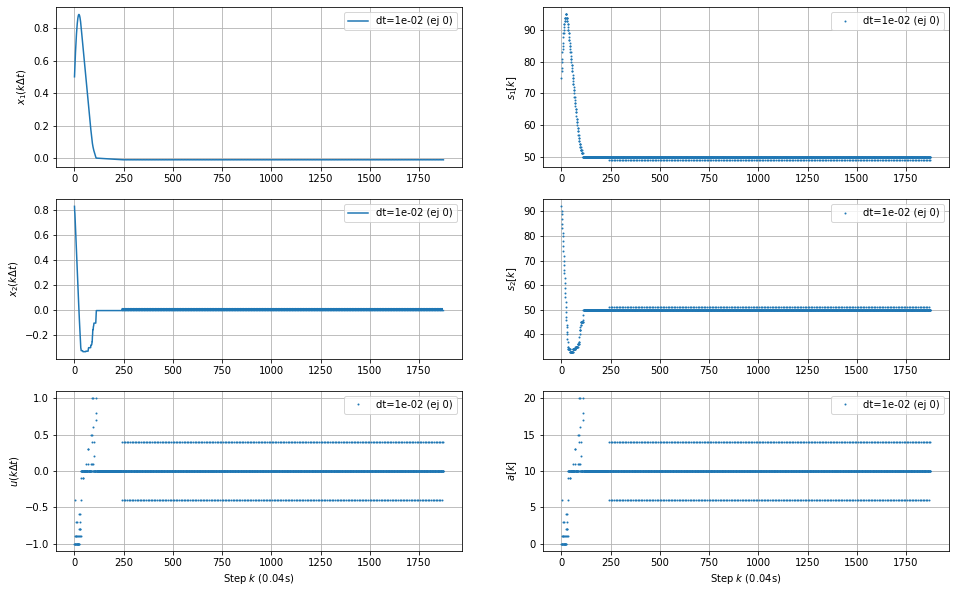

In [28]:
x0 = np.array([[0.5, 0.83], [-0.5, -0.83], [0.45, -0.1]])
A = np.array([[0.0,1.0],[0.0,0.0]])
B = np.array([[0.0],[1.0]])
ode_args = {'A': A.copy(), 'B': B.copy()}

fig, ax = plt.subplots(3,2, figsize=(16,10))
dt = 0.04
dt_sim = 0.01
t = np.arange(0.0,75.0,dt_sim)
t_k = np.arange(0.0,75.0+dt,dt)  
x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args, 
                                                policy_type='given_policy', policy=policy1)
k = np.arange(0,len(x))
for i in range(0, 1): 
  label_ = "dt=%.0e"%dt_sim+" (ej "+str(i)+")"   
  ax[0,0].plot(k, x[:,i,0], '-', ms=1, label=label_)
  ax[1,0].plot(k, x[:,i,1], '-', ms=1, label=label_)
  ax[2,0].plot(k, u[:,i,0], 'o', ms=1, label=label_)
  ax[0,1].plot(k, s[:,i,0], 'o', ms=1, label=label_)
  ax[1,1].plot(k, s[:,i,1], 'o', ms=1, label=label_)
  ax[2,1].plot(k, a[:,i,0], 'o', ms=1, label=label_)
ax[2,0].set_xlabel('Step $k$ (0.04s)')
ax[2,1].set_xlabel('Step $k$ (0.04s)')
ax[0,0].set_ylabel('$x_1(k\Delta t)$')
ax[0,1].set_ylabel('$s_1[k]$')
ax[1,0].set_ylabel('$x_2(k\Delta t)$')
ax[1,1].set_ylabel('$s_2[k]$')
ax[2,0].set_ylabel('$u(k\Delta t)$')
ax[2,1].set_ylabel('$a[k]$')
for i in range(0,3):
  for j in range(0,2):
    ax[i,j].grid()
    ax[i,j].legend(fontsize=10)
plt.show()
plt.close() 

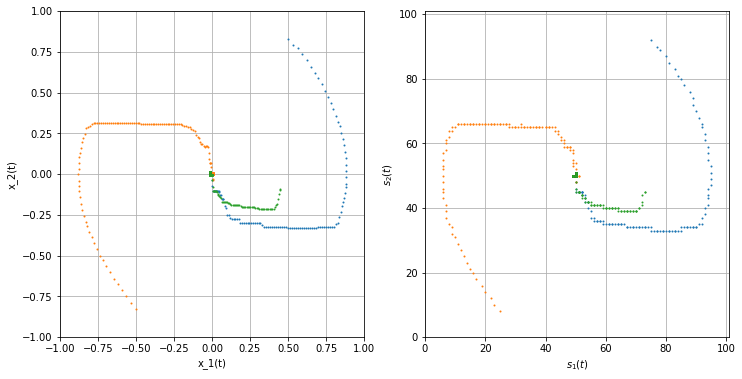

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i in range(0, x0.shape[0]): 
  ax[0].plot(x[:,i,0], x[:,i,1], 'o', ms=1)
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_xlabel(r'x_1(t)')
ax[0].set_ylabel(r'x_2(t)')

for i in range(0, x0.shape[0]): 
  ax[1].plot(s[:,i,0], s[:,i,1], 'o', ms=1)
ax[1].set_xlim([0,101])
ax[1].set_ylim([0,101])
ax[1].set_xlabel(r'$s_1(t)$')
ax[1].set_ylabel(r'$s_2(t)$')

for i in range(0, 2):
  ax[i].grid() 
plt.show()
plt.close() 

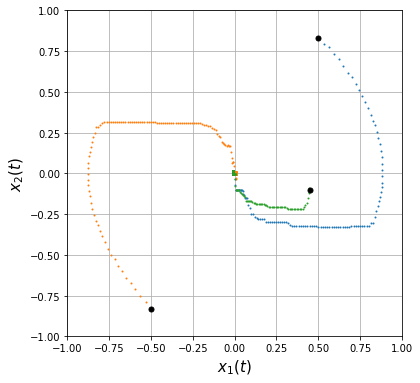

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

for i in range(0, x0.shape[0]): 
  ax.plot(x[:,i,0], x[:,i,1], 'o', ms=1)
  ax.plot(x[0,i,0], x[0,i,1], 'o', c='k', ms=5)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel(r'$x_1(t)$', fontsize=15)
ax.set_ylabel(r'$x_2(t)$', fontsize=15)

ax.grid() 
plt.savefig('trajectories_pi_opt.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()
plt.close()  

In [ ]:
J_table1, Q_table1 = J_table.copy(), Q_table.copy()

In [ ]:
for i in range(0,15): #25
  J_table1, Q_table1 = update_tables(J_table1, Q_table1, n_iter=10, alpha=1e-2)

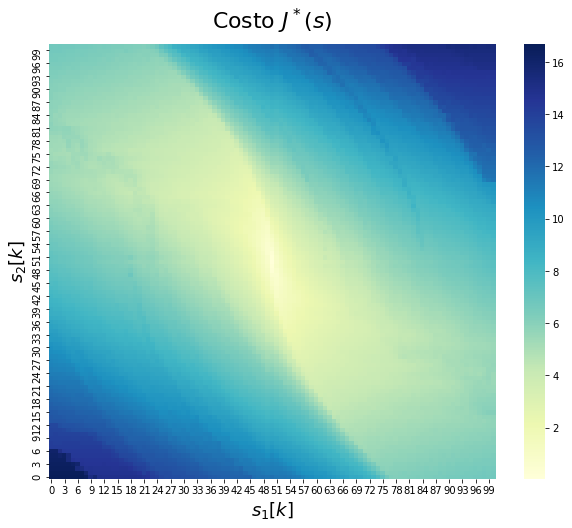

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
# sns_ax = sns.heatmap(np.log(J_table1.T-J_table1.min()+1e-1), ax=ax, cmap='YlGnBu')
sns_ax = sns.heatmap(J_table1.T, ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
ax.set_xlabel('$s_1[k]$', fontsize=18)
ax.set_ylabel('$s_2[k]$', fontsize=18)
plt.title('Costo $J^*(s)$', fontsize=22, pad=15)
plt.savefig('J_DP.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()
plt.close()

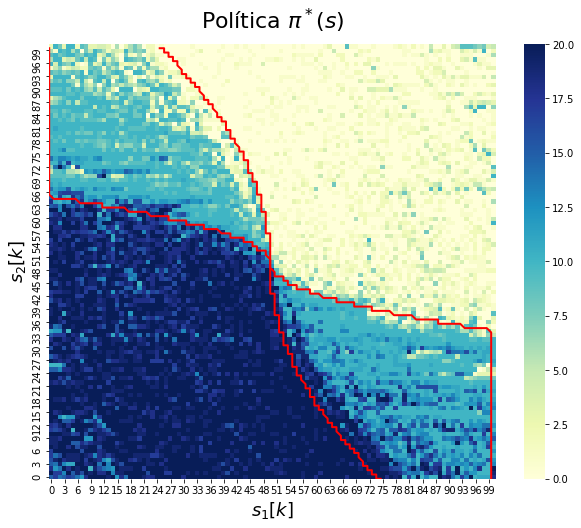

In [26]:
policy1 = Q_table1.argmin(axis=2)

x21=np.linspace(-1, 1, 1000)
x11=-0.5*x21*np.abs(x21)
curve1 = np.concatenate([x11, x21])
curve1_s = x2s(curve1)

lambda_=1.0/5.0
x22=np.linspace(-1,  1, 1000)
x12=-((lambda_+4)/(2*lambda_))*x22*np.abs(x22)

s11 = x2s(x11)
s12 = x2s(x12)
s21 = x2s(x21)
s22 = x2s(x22)

fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(policy1.T, ax=ax, cmap='YlGnBu')
ax.plot(s11, s21, 'r', linewidth=2)
ax.plot(s12, s22, 'r', linewidth=2)
sns_ax.invert_yaxis()
ax.set_xlabel('$s_1[k]$', fontsize=18)
ax.set_ylabel('$s_2[k]$', fontsize=18)
plt.title('Política $\pi^*(s)$', fontsize=22, pad=15)
plt.savefig('PDvsVC.pdf', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()
plt.close()

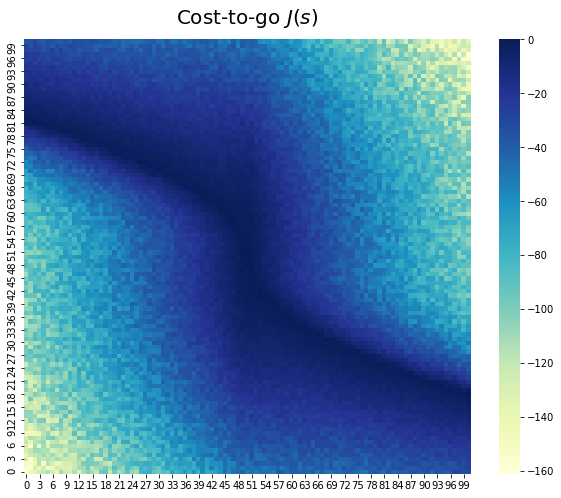

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(J_table1.T-J_table.T, ax=ax, cmap='YlGnBu')
# sns_ax = sns.heatmap(J_table1.T, ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.title('Cost-to-go $J(s)$', fontsize=20, pad=15)
plt.show()
plt.close()

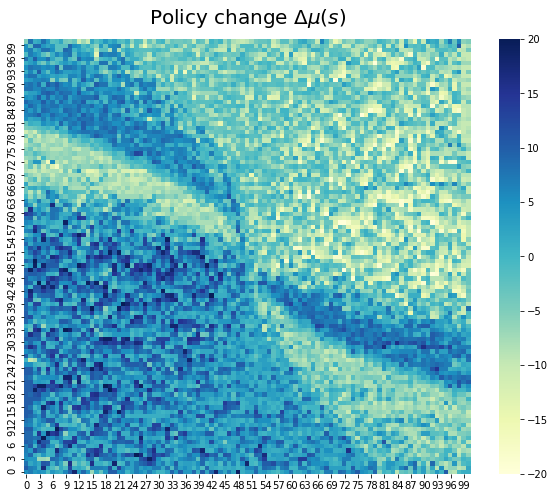

In [32]:
policy1 = Q_table1.argmin(axis=2)
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(policy1.T-policy.T, ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.title('Policy change $\Delta\mu(s)$', fontsize=20, pad=15)
plt.show()
plt.close()

# 4. Aproximate DP

We define now the classes of the agent and the critic. The critic in this case will learn the gradient $\nabla_xJ$, given that the dimensionality of $x$ is small and we do know the step cost $g(x,u)$ and the dynamics $f(x,u)$.

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [107]:
def init_weights_big(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, 0.0, 1.0)
        m.bias.data.fill_(0.0)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, 0.0, 0.01)
        m.bias.data.fill_(0.0)

class actor_net(nn.Module):
  def __init__(self):
    super(actor_net, self).__init__()
    self.pipe = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Tanh(),
    )
    self.apply(init_weights)

  def forward(self, x):
    u = self.pipe(x)
    return u

class critic_net(nn.Module):
  def __init__(self):
    super(critic_net, self).__init__()
    self.pipe = nn.Sequential(
        nn.Linear(2, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 2),
    )
    self.apply(init_weights)

  def forward(self, x):
    gradJ = self.pipe(x)
    return gradJ

class critic_J_net(nn.Module):
  def __init__(self):
    super(critic_J_net, self).__init__()
    self.pipe = nn.Sequential(
        nn.Linear(2, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 1),
    )
    self.apply(init_weights)

  def forward(self, x):
    J = self.pipe(x)
    return J

class critic_Q_net(nn.Module):
  def __init__(self):
    super(critic_Q_net, self).__init__()
    self.pipe = nn.Sequential(
        nn.Linear(3, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 1),
    )
    self.apply(init_weights)

  def forward(self, x, u):
    xu = torch.cat([x,u], axis=1)
    Q = self.pipe(xu)
    return Q

In [108]:
def calculate_g(x,u, eps=5e-2, w_fuel=5.0):
  distance_to_origin = x.pow(2).sum(1, keepdim=True)**0.5
  not_in_origin = (distance_to_origin >= eps).float()
  g = not_in_origin * (1.0 + w_fuel * u.abs())  
  return g.reshape(-1)

# Same as system_ode, but for torch arrays
def calculate_f(x, u, args):
  A = torch.FloatTensor(args['A']); B = torch.FloatTensor(args['B'])
  xdot = torch.einsum('ij,kj->ki',A,x) + torch.einsum('ij,kj->ki',B,u)  
  return xdot

def train_critic(actor, critic, n_points=1000, n_steps=100,
                 verbose=False, print_each=10):
  for step in range(0, n_steps):
    x = generate_init_states_grid()
    x_with_noise = x + generate_state_noise(n_points=x.shape[0])
    x_torch = torch.FloatTensor(x_with_noise)
    u_torch = actor(x_torch)
    g = calculate_g(x_torch, u_torch)
    f = calculate_f(x_torch, u_torch, args=ode_args)
    gradJ = critic(x_torch)
    loss = (g + torch.einsum('ij,ij->i', gradJ, f)).pow(2).mean()

    optimizer_critic.zero_grad()
    loss.backward() 
    clip_grad_norm_(critic.parameters(), 1.0)
    optimizer_critic.step()   

    if verbose and ((step+1)%print_each==0):
      print('Step: {}, Loss: {:.3e}'.format(step, loss.item())) 

def train_actor(actor, critic, n_points=1000, n_steps=100,
                 verbose=False, print_each=10):
  for step in range(0, n_steps):
    x = generate_init_states_grid()
    x_with_noise = x + generate_state_noise(n_points=x.shape[0])
    x_torch = torch.FloatTensor(x_with_noise)
    u_torch = actor(x_torch)
    g = calculate_g(x_torch, u_torch)
    f = calculate_f(x_torch, u_torch, args=ode_args)
    gradJ = critic(x_torch)
    loss = (g + torch.einsum('ij,ij->i', gradJ, f)).mean()

    optimizer_actor.zero_grad()
    loss.backward() 
    clip_grad_norm_(actor.parameters(), 1.0)
    optimizer_actor.step()

    if verbose and ((step+1)%print_each==0):
      print('Step: {}, Loss: {:.3e}'.format(step, loss.item()))    

def train_actor_critic(actor, critic, n_cicles=1000):
  for cicle in range(0, n_cicles):
    print(cicle)
    # print(cicle, 'Train critic')
    train_critic(actor, critic, verbose=False, n_steps=200, print_each=20, n_points=256)
    # print(cicle, 'Train actor')
    train_actor(actor, critic, verbose=False, n_steps=400, print_each=40, n_points=4056)

def train_critic_J(actor, criticJ, optimizer_criticJ, NS=101, n_points=100, n_steps=200, 
                   dt_sim=0.01, dt=0.04, verbose=False, print_each=10, init=False, batch_size=64):
  t = np.arange(0,10.0*dt+dt_sim,dt_sim)
  t_k = np.arange(0,10.0*dt+2*dt,dt)  
  for step in range(0, n_steps):
    if init:
      x0 = generate_init_states_grid()
      x0 = x0 + generate_state_noise(n_points=x0.shape[0])
    else:
      x0 = generate_init_states(n_points)
    x, s, a, u = simulate_trajectory_DormandPrince_actor(system_ode,t,t_k,x0,
                                                         ode_args,actor)
    s0 = s[0,:,:]
    x_end_torch = torch.FloatTensor(x[-1,:,:])
    J_end = criticJ(x_end_torch).view(-1).detach()
    
    J = []
    for i in range(0, x0.shape[0]):
      trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
      J.append(calculate_J_trajectory_actor(trajectory, J_end[i], dt=dt))    
    J = torch.FloatTensor(J).view(-1)

    n_batches = x0.shape[0] // batch_size
    # for batch in range(0, n_batches):
    # J_batch = J[batch*batch_size: (batch+1)*batch_size,:]
    # x0_torch = torch.FloatTensor(x0[batch*batch_size: (batch+1)*batch_size,:])
    indices = np.sort(np.arange(0, x0.shape[0]))
    for batch in range(0, n_batches):
      id_batch = indices[batch*batch_size: (batch+1)*batch_size]
      J_batch = J[id_batch]
      x0_torch = torch.FloatTensor(x0[id_batch])
      J_estimated = criticJ(x0_torch).view(-1)
      loss = ((1.0-J_estimated.div(J_batch+1e-4))**2).mean()

      optimizer_criticJ.zero_grad()
      loss.backward() 
      clip_grad_norm_(criticJ.parameters(), 1.0)
      optimizer_criticJ.step()

    if verbose and ((step+1)%print_each==0):
      print('Step: {}, Loss: {:.3e}, Mean J: {:.3e}, Mean u: {:.3e}'.format(step, loss.item(), J.mean(), np.absolute(u).mean()))

def train_critic_Q(actor, criticQ, criticJ, optimizer_criticQ, NS=101, n_points=100, n_steps=200, 
                   dt_sim=0.01, dt=0.04, verbose=False, print_each=10, init=False, batch_size=64):
  t = np.arange(0,10.0*dt+dt_sim,dt_sim)
  t_k = np.arange(0,10.0*dt+2*dt,dt)  
  for step in range(0, n_steps):
    if init:
      x0 = generate_init_states_grid()
      x0 = x0 + generate_state_noise(n_points=x0.shape[0])
    else:
      x0 = generate_init_states(n_points)
    x, s, a, u = simulate_trajectory_DormandPrince_actor(system_ode,t,t_k,x0,
                                                         ode_args,actor, rand_init=True)
    u0 = u[0,:,:]
    x_end_torch = torch.FloatTensor(x[-1,:,:])
    J_end = criticJ(x_end_torch).view(-1).detach()
    
    J = []
    for i in range(0, x0.shape[0]):
      trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
      J.append(calculate_J_trajectory_actor(trajectory, J_end[i], dt=dt))    
    J = torch.FloatTensor(J).view(-1)

    n_batches = x0.shape[0] // batch_size
    # for batch in range(0, n_batches):
    # J_batch = J[batch*batch_size: (batch+1)*batch_size,:]
    # x0_torch = torch.FloatTensor(x0[batch*batch_size: (batch+1)*batch_size,:])
    indices = np.sort(np.arange(0, x0.shape[0]))
    for batch in range(0, n_batches):
      id_batch = indices[batch*batch_size: (batch+1)*batch_size]
      J_batch = J[id_batch]
      x0_torch = torch.FloatTensor(x0[id_batch])
      u0_torch = torch.FloatTensor(u0[id_batch])
      Q_estimated = criticQ(x0_torch, u0_torch).view(-1)
      loss = ((1.0-Q_estimated.div(J_batch+1e-4))**2).mean()

      optimizer_criticQ.zero_grad()
      loss.backward() 
      clip_grad_norm_(criticQ.parameters(), 1.0)
      optimizer_criticQ.step()

    if verbose and ((step+1)%print_each==0):
      print('Step: {}, Loss: {:.3e}, Mean J: {:.3e}, Mean u: {:.3e}'.format(step, loss.item(), J.mean(), np.absolute(u).mean()))

In [100]:
# torch.save(actor.state_dict(), 'actor1.pt')
# torch.save(critic.state_dict(), 'critic1.pt')
torch.save(criticJ.state_dict(), 'criticJ0.pt')

# actor.load_state_dict(torch.load('actor0.pt'))  
# critic.load_state_dict(torch.load('critic0.pt')) 
# criticJ.load_state_dict(torch.load('criticJ0.pt'))  

In [115]:
# actor = actor_net()
# critic = critic_net()
# criticJ = critic_J_net()
criticQ = critic_Q_net()
optimizer_actor = optim.Adam(actor.parameters(), lr=3e-4) 
optimizer_critic = optim.Adam(critic.parameters(), lr=3e-4) 
optimizer_criticJ = optim.Adam(criticJ.parameters(), lr=3e-3) 
optimizer_criticQ = optim.Adam(criticQ.parameters(), lr=3e-3) 

In [97]:
train_critic_J(actor, criticJ, optimizer_criticJ, n_points=2000, n_steps=500, print_each=50, verbose=True, init=True, batch_size=101*101)

Step: 49, Loss: 1.215e-02, Mean J: 3.698e+02, Mean u: 3.339e-04
Step: 99, Loss: 1.236e-02, Mean J: 3.702e+02, Mean u: 3.337e-04
Step: 149, Loss: 1.288e-02, Mean J: 3.715e+02, Mean u: 3.337e-04
Step: 199, Loss: 1.242e-02, Mean J: 3.707e+02, Mean u: 3.337e-04
Step: 249, Loss: 1.241e-02, Mean J: 3.713e+02, Mean u: 3.338e-04
Step: 299, Loss: 1.248e-02, Mean J: 3.725e+02, Mean u: 3.338e-04
Step: 349, Loss: 1.282e-02, Mean J: 3.699e+02, Mean u: 3.338e-04
Step: 399, Loss: 6.325e-02, Mean J: 3.736e+02, Mean u: 3.338e-04
Step: 449, Loss: 1.280e-02, Mean J: 3.734e+02, Mean u: 3.338e-04
Step: 499, Loss: 1.270e-02, Mean J: 3.733e+02, Mean u: 3.338e-04


In [116]:
train_critic_Q(actor, criticQ, criticJ, optimizer_criticQ, n_points=2000, n_steps=500, print_each=50, verbose=True, init=True, batch_size=101*101)

Step: 49, Loss: 9.936e-01, Mean J: 3.736e+02, Mean u: 4.523e-02
Step: 99, Loss: 9.966e-01, Mean J: 3.733e+02, Mean u: 4.621e-02
Step: 149, Loss: 9.882e-01, Mean J: 3.735e+02, Mean u: 4.595e-02
Step: 199, Loss: 9.505e-01, Mean J: 3.734e+02, Mean u: 4.579e-02
Step: 249, Loss: 7.823e-01, Mean J: 3.733e+02, Mean u: 4.529e-02
Step: 299, Loss: 5.407e-01, Mean J: 3.734e+02, Mean u: 4.581e-02
Step: 349, Loss: 3.804e-01, Mean J: 3.734e+02, Mean u: 4.586e-02
Step: 399, Loss: 2.930e-01, Mean J: 3.729e+02, Mean u: 4.561e-02
Step: 449, Loss: 2.091e-01, Mean J: 3.735e+02, Mean u: 4.584e-02
Step: 499, Loss: 1.252e-01, Mean J: 3.735e+02, Mean u: 4.620e-02


In [101]:
train_critic(actor, critic, verbose=True, n_steps=400, print_each=40, n_points=256) #30000/512

Step: 39, Loss: 1.000e+00
Step: 79, Loss: 9.911e-01
Step: 119, Loss: 9.624e-01
Step: 159, Loss: 9.087e-01
Step: 199, Loss: 8.261e-01
Step: 239, Loss: 7.219e-01
Step: 279, Loss: 6.098e-01
Step: 319, Loss: 5.123e-01
Step: 359, Loss: 4.450e-01
Step: 399, Loss: 4.081e-01


In [1893]:
actor = actor_net()
optimizer_actor = optim.Adam(actor.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-8) 

In [2007]:
train_actor(actor, critic, verbose=True, n_steps=400, print_each=40, n_points=4056) # 5000/1024 

Step: 39, Loss: 6.500e-03
Step: 79, Loss: 6.170e-03
Step: 119, Loss: 7.653e-03
Step: 159, Loss: 5.911e-03
Step: 199, Loss: 6.455e-03
Step: 239, Loss: 6.644e-03
Step: 279, Loss: 6.017e-03
Step: 319, Loss: 6.193e-03
Step: 359, Loss: 7.474e-03
Step: 399, Loss: 5.731e-03


In [2005]:
train_actor_critic(actor, critic, n_cicles=10)

0
1
2
3
4
5
6
7
8
9


In [2020]:
with torch.no_grad():
  x = generate_init_states_grid()
  x_torch = torch.FloatTensor(x)
  u_torch = actor(x_torch)
  g = calculate_g(x_torch, u_torch).detach().numpy()
  f = calculate_f(x_torch, u_torch, args=ode_args).detach().numpy()
  gradJ = critic(x_torch).detach().numpy()
  loss = (g + np.einsum('ij,ij->i', gradJ, f)).reshape(101,101)

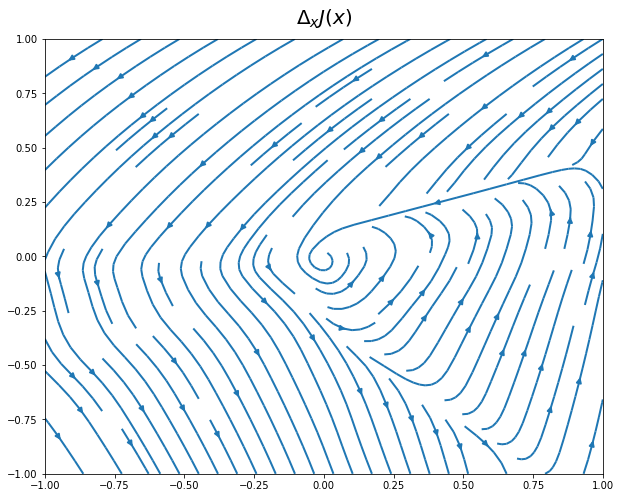

In [2021]:
gradJ1 = gradJ.reshape(101,101,2)[:,:,0]
gradJ2 = gradJ.reshape(101,101,2)[:,:,1]
xx = np.linspace(-1.0,1.0,101)
X, Y = np.meshgrid(xx,xx)

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.streamplot(X, Y, gradJ1, gradJ2, linewidth=2, cmap='autumn')
plt.title('$\Delta_x J(x)$', fontsize=20, pad=15)
plt.show()
plt.close()

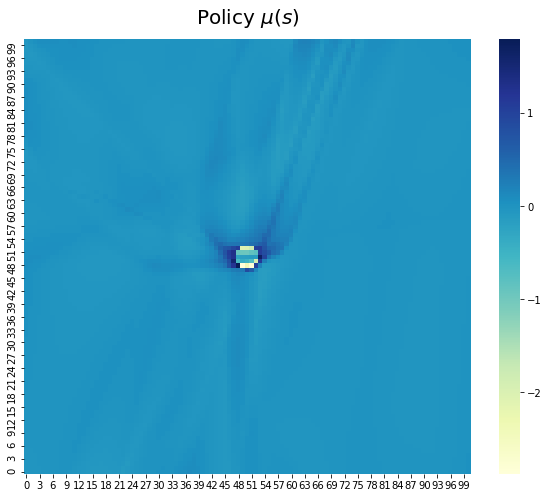

In [2022]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(loss.T, ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.title('Policy $\mu(s)$', fontsize=20, pad=15)
plt.show()
plt.close()

In [117]:
with torch.no_grad():
  x = generate_init_states_grid()
  x = x[np.arange(x.shape[0]-1,-1,-1)]
  x_torch = torch.FloatTensor(x)
  u_torch = actor(x_torch)
  u = u_torch.numpy().reshape(101,101)
  J = criticJ(x_torch).numpy().reshape(101,101)
  Q = criticQ(x_torch, u_torch).numpy().reshape(101,101)

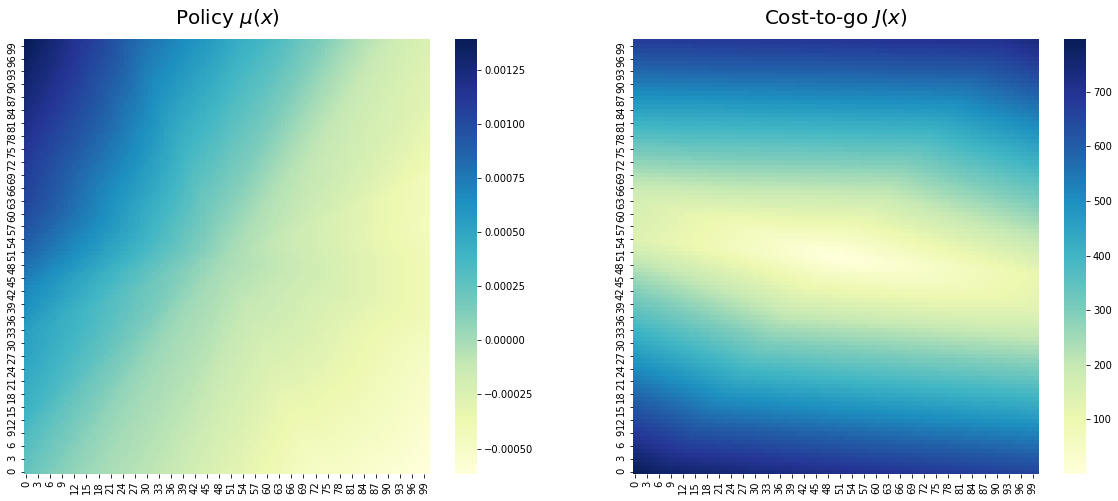

In [99]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns_ax = sns.heatmap(u, ax=ax[0], cmap='YlGnBu')
sns_ax.invert_yaxis()
sns_ax2 = sns.heatmap(J, ax=ax[1], cmap='YlGnBu')
sns_ax2.invert_yaxis()
ax[0].set_title('Policy $\mu(x)$', fontsize=20, pad=15)
ax[1].set_title('Cost-to-go $J(x)$', fontsize=20, pad=15)
plt.show()
plt.close()

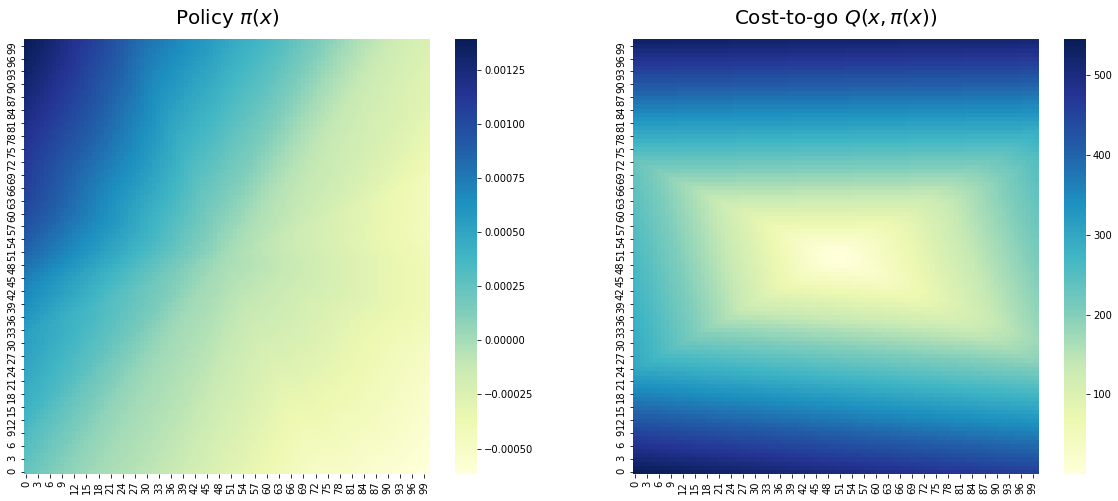

In [118]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns_ax = sns.heatmap(u, ax=ax[0], cmap='YlGnBu')
sns_ax.invert_yaxis()
sns_ax2 = sns.heatmap(Q, ax=ax[1], cmap='YlGnBu')
sns_ax2.invert_yaxis()
ax[0].set_title('Policy $\pi(x)$', fontsize=20, pad=15)
ax[1].set_title('Cost-to-go $Q(x,\pi(x))$', fontsize=20, pad=15)
plt.show()
plt.close()

In [ ]:
# def train_critic_J(actor, criticJ, optimizer_criticJ, NS=101, n_points=100, n_steps=200, 
#                    dt_sim=0.01, dt=0.04, verbose=False, print_each=10, init=False):
#   t = np.arange(0,20.0+dt_sim,dt_sim)
#   t_k = np.arange(0,20.0+2*dt,dt)  
#   for step in range(0, n_steps):
#     if init:
#       x0 = generate_init_states_grid()
#     else:
#       x0 = generate_init_states(n_points)
#     x, s, a, u = simulate_trajectory_DormandPrince_actor(system_ode,t,t_k,x0,
#                                                          ode_args,actor)
#     s0 = s[0,:,:]

#     x_end_torch = torch.FloatTensor(x[-1,:,:])
#     if init:
#       J_end = np.zeros(x_end_torch.shape[0])
#     else:
#       J_end = criticJ(x_end_torch).view(-1).detach()

#     J = []
#     for i in range(0, x0.shape[0]):
#       trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
#       J.append(calculate_J_trajectory_actor(trajectory, J_end[i], dt=dt))
    
#     J = torch.FloatTensor(J).view(-1,1)
#     x0_torch = torch.FloatTensor(x0)
#     J_estimated = criticJ(x0_torch).view(-1,1)
#     loss = (((J-J_estimated)/10.0)**2).mean()

#     optimizer_criticJ.zero_grad()
#     loss.backward() 
#     clip_grad_norm_(criticJ.parameters(), 1.0)
#     optimizer_criticJ.step()

#     if verbose and ((step+1)%print_each==0):
#       print('Step: {}, Loss: {:.3e}, Mean J: {:.3e}'.format(step, loss.item(), J.mean()))        


# def train_critic_J(actor, criticJ, optimizer_criticJ, NS=101, n_points=100, n_steps=200, 
#                    dt_sim=0.01, dt=0.04, verbose=False, print_each=10, init=False, batch_size=64):
#   t = np.arange(0,70.0+dt_sim,dt_sim)
#   t_k = np.arange(0,70.0+2*dt,dt)  
#   for step in range(0, n_steps):
#     if init:
#       x0 = generate_init_states_grid()
#       x0 = x0 + generate_state_noise(n_points=x0.shape[0])
#     else:
#       x0 = generate_init_states(n_points)
#     x, s, a, u = simulate_trajectory_DormandPrince_actor(system_ode,t,t_k,x0,
#                                                          ode_args,actor)
#     s0 = s[0,:,:]
#     x_end_torch = torch.FloatTensor(x[-1,:,:])

#     if init:
#       J_end = np.zeros(x_end_torch.shape[0])
#     else:
#       J_end = criticJ(x_end_torch).view(-1).detach()
    
#     J = []
#     for i in range(0, x0.shape[0]):
#       trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
#       J.append(calculate_J_trajectory_actor(trajectory, J_end[i], dt=dt))    
#     J = torch.FloatTensor(J).view(-1,1)

#     n_batches = x0.shape[0] // batch_size
#     indices = np.sort(np.arange(0, x0.shape[0]))
#     for batch in range(0, n_batches):
#       id_batch = indices[batch*batch_size: (batch+1)*batch_size]
#       J_batch = J[id_batch]
#       x0_torch = torch.FloatTensor(x0[id_batch])
#       J_estimated = criticJ(x0_torch).view(-1,1)
#       loss = (((J_batch-J_estimated)/100.0)**2).mean()

#       optimizer_criticJ.zero_grad()
#       loss.backward() 
#       # clip_grad_norm_(criticJ.parameters(), 1.0)
#       optimizer_criticJ.step()

#     if verbose and ((step+1)%print_each==0):
#       print('Step: {}, Loss: {:.3e}, Mean J: {:.3e}, Mean u: {:.3e}'.format(step, loss.item(), J.mean(), np.absolute(u).mean()))

In [66]:
dt_sim = 0.01
dt = 0.04
t = np.arange(0,10.0*dt+dt_sim,dt_sim)
t_k = np.arange(0,10.0*dt+2*dt,dt) 
x0 = generate_init_states_grid()
x0 = x0 + generate_state_noise(n_points=x0.shape[0])
x, s, a, u = simulate_trajectory_DormandPrince_actor(system_ode,t,t_k,x0,
                                                        ode_args,actor)
s0 = s[0,:,:]
x_end_torch = torch.FloatTensor(x[-1,:,:])
J_end = criticJ(x_end_torch).view(-1).detach()

J = []
for i in range(0, x0.shape[0]):
  trajectory = (x[:,i,:], s[:,i,:], a[:,i,:], u[:,i,:])
  J.append(calculate_J_trajectory_actor(trajectory, 0.0, dt=dt))    
J = torch.FloatTensor(J).view(-1)

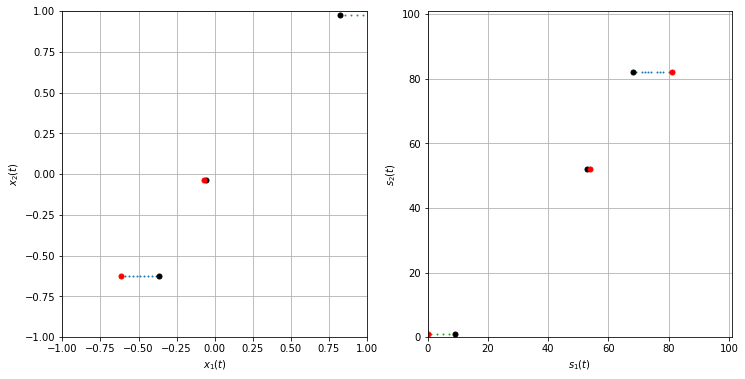

In [67]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i in [1850,4895,10090]: 
  ax[0].plot(x[:,i,0], x[:,i,1], 'o', ms=1)
  ax[0].plot(x[0,i,0], x[0,i,1], 'o', c='k', ms=5)
  ax[0].plot(x[-1,i,0], x[-1,i,1], 'o', c='r', ms=5)
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_xlabel(r'$x_1(t)$')
ax[0].set_ylabel(r'$x_2(t)$')

for i in [1850,4895,10090]: 
  ax[1].plot(s[:,-i-1,0], s[:,-i-1,1], 'o', ms=1)
  ax[1].plot(s[0,-i-1,0], s[0,-i-1,1], 'o', c='k', ms=5)
  ax[1].plot(s[-1,-i-1,0], s[-1,-i-1,1], 'o', c='r', ms=5)
ax[1].set_xlim([0,101])
ax[1].set_ylim([0,101])
ax[1].set_xlabel(r'$s_1(t)$')
ax[1].set_ylabel(r'$s_2(t)$')

for i in range(0, 2):
  ax[i].grid() 
# plt.savefig('trajectories_pi_opt.pdf', dpi=300, bbox_inches = 'tight',
#     pad_inches = 0)
plt.show()
plt.close()  

In [68]:
batch_size = 101*101
n_batches = x0.shape[0] // batch_size 
indices = np.arange(0, x0.shape[0]).tolist()
np.random.shuffle(indices)
batch = 0
id_batch = indices[batch*batch_size: (batch+1)*batch_size]
J_batch = J[id_batch]
x0_torch = torch.FloatTensor(x0[id_batch])
J_estimated = criticJ(x0_torch).view(-1)
loss = (((J_batch-J_estimated)/100.0)**2).mean()

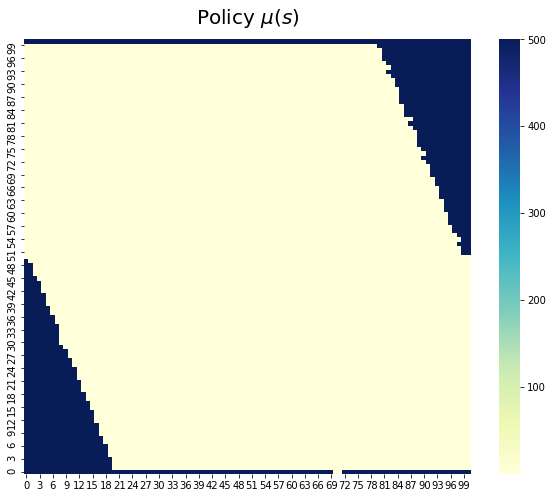

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(J.detach().numpy().reshape(101,101), ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.title('Policy $\mu(s)$', fontsize=20, pad=15)
plt.show()
plt.close()

In [ ]:
optimizer_criticJ.zero_grad()
loss.backward() 
# clip_grad_norm_(criticJ.parameters(), 1.0)
optimizer_criticJ.step()